In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import precision_score, average_precision_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
def gen_y(label_str):
  # print(label_str)
  out = pd.Series({'label_%d' % (i) : 0 for i in range(11)})
  labels = str(label_str).split(' ')
  for l in labels:
    out['label_%s' % (l)] = 1
  # out['old_label'] = label_str
  return out

In [ ]:
# IDs dos segmentos - Treino e validação
train_seg_key = pd.read_csv('https://raw.githubusercontent.com/newsdata/SoccerDB/master/dataset/video_dataset/train_seg_key.csv', header=None).to_numpy().flatten()
validation_seg_key = pd.read_csv('https://raw.githubusercontent.com/newsdata/SoccerDB/master/dataset/video_dataset/val_seg_key.csv', header=None).to_numpy().flatten()

In [ ]:
# Lendo csv das médias dos descritores
df = pd.read_csv('/content/drive/MyDrive/TCC/mean_median_std_segments.csv')
df = df.drop(df.columns[0], axis=1)
df.columns

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['seg_id', 'cls_id', 'MEAN_0', 'MEAN_1', 'MEAN_2', 'MEAN_3', 'MEAN_4',
       'MEAN_5', 'MEAN_6', 'MEAN_7',
       ...
       'STD_502', 'STD_503', 'STD_504', 'STD_505', 'STD_506', 'STD_507',
       'STD_508', 'STD_509', 'STD_510', 'STD_511'],
      dtype='object', length=1538)

In [ ]:
df

,seg_id,cls_id,MEAN_0,MEAN_1,MEAN_2,MEAN_3,MEAN_4,MEAN_5,MEAN_6,MEAN_7,...,STD_502,STD_503,STD_504,STD_505,STD_506,STD_507,STD_508,STD_509,STD_510,STD_511
0,73ed8378dc1811e897b86c96cfde8f_1_100_origin_00...,0,1.040726,2.908433,5.415557,13.534303,49.408671,7.962034,7.995172,28.459100,...,6.651066,12.199374,6.352187,8.361165,15.376564,15.860730,14.822319,0.672305,10.016976,32.897059
1,73ed8378dc1811e897b86c96cfde8f_1_100_origin_00...,0,18.146216,1.707686,4.817236,0.676112,19.250017,9.303244,5.053849,7.443971,...,9.899844,6.174066,4.070407,5.397249,10.849989,14.969843,8.271197,0.000000,5.937074,11.665777
2,73ed8378dc1811e897b86c96cfde8f_1_100_origin_00...,0,6.651225,9.502874,4.540128,2.841258,44.545239,9.295176,7.739557,36.735191,...,8.008388,8.146741,11.920758,4.556942,26.401784,22.236139,7.366693,2.371284,12.548949,20.013665
3,73ed8378dc1811e897b86c96cfde8f_1_100_origin_00...,0,2.883687,2.765757,8.453304,2.574604,44.726872,22.009967,9.790131,36.523389,...,3.463994,4.980632,8.714601,0.992832,18.120816,12.276475,9.022244,2.176398,8.175290,8.809985
4,73ed8378dc1811e897b86c96cfde8f_1_100_origin_00...,0,4.520419,5.779800,1.164119,1.504031,76.732398,17.580343,3.086707,34.092898,...,7.198753,11.361748,11.533055,0.911559,11.389960,18.005052,8.604114,2.448005,6.959429,18.423832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142570,ddce0e38d5ac11e8b2536c96cfde8f_100_origin_0000...,0,25.427629,1.323690,8.090103,0.900039,55.190589,32.435169,42.890131,26.021780,...,3.719114,12.297446,9.117653,11.437620,19.607629,14.154165,12.230365,0.000000,5.354950,17.929084
142571,ddce0e38d5ac11e8b2536c96cfde8f_100_origin_0000...,0,26.254412,1.252541,14.117269,3.748907,57.738189,33.056517,17.373277,19.037986,...,5.053526,12.297322,8.222824,9.776666,19.345532,14.360757,8.234063,0.378767,6.694472,39.687998
142572,ddce0e38d5ac11e8b2536c96cfde8f_100_origin_0000...,0,53.289957,1.565482,9.580962,0.000000,62.946877,22.718227,33.920024,12.351120,...,1.995447,9.030263,4.691851,7.284102,18.587420,8.953388,3.409957,0.000000,2.637709,2.421959
142573,ddce0e38d5ac11e8b2536c96cfde8f_115-8a0b0941-dd...,9,25.521953,1.378544,16.250499,0.000000,82.817625,52.935982,16.828717,5.987653,...,6.837419,21.049185,5.778025,9.117961,15.157445,5.043188,5.732983,7.560027,4.915330,9.009602


In [ ]:
train_df = df.loc[df['seg_id'].isin(train_seg_key)]
validation_df = df.loc[df['seg_id'].isin(validation_seg_key)]

In [ ]:
y_train = train_df['cls_id'].apply(gen_y)
x_train = train_df.drop(['cls_id', 'seg_id'], axis=1)

y_test = validation_df['cls_id'].apply(gen_y)
x_test = validation_df.drop(['cls_id', 'seg_id'], axis=1)

In [ ]:
def predict_proba(model, x):
  y_pred = model.predict_proba(x)
  out = np.zeros((len(y_pred[0]), len(y_pred)))
  for i in range(len(y_pred)):
    out[:, i] = y_pred[i][:, 1]
  return out

In [ ]:
y_pred = predict_proba(moc, x_test)

In [ ]:
y_pred

array([[9.15730904e-01, 1.94037050e-03, 2.50095397e-03, ...,
        4.81346995e-04, 3.30390953e-02, 7.74703786e-03],
       [8.47891908e-01, 1.91091718e-03, 1.52314367e-03, ...,
        4.55924996e-04, 3.72777011e-02, 1.03688711e-02],
       [8.95920374e-01, 1.98183362e-03, 3.35252573e-03, ...,
        3.71042661e-04, 2.74629011e-02, 4.75104181e-03],
       ...,
       [8.60669313e-01, 1.52989032e-03, 1.99583898e-03, ...,
        3.11978545e-04, 2.81153241e-02, 9.92911712e-03],
       [9.65976786e-01, 4.07664503e-03, 5.04258548e-03, ...,
        5.19341755e-04, 3.15659090e-03, 3.69673892e-03],
       [8.30232129e-01, 7.32140435e-03, 9.70220594e-03, ...,
        7.75775889e-04, 2.72467420e-02, 4.00044745e-02]])

In [ ]:
average_precision_score(y_test, y_pred)

0.2430820859639233

In [ ]:
roc_auc_score(y_test, y_pred, average=None)

array([0.79210761, 0.76591046, 0.86986199, 0.87919134, 0.97111179,
       0.81539775, 0.93430915, 0.85300495, 0.83873254, 0.75511843,
       0.85760538])

In [ ]:
for i in range(11):
  print(i, roc_auc_score(y_test.values[:, i], y_pred[:, i]))

0 0.7921076100209972
1 0.7659104578319699
2 0.8698619863887636
3 0.8791913371070698
4 0.9711117933951282
5 0.815397752639849
6 0.9343091476936373
7 0.8530049478699244
8 0.8387325441647256
9 0.7551184312962701
10 0.8576053841238431


In [ ]:
pipe_rf = Pipeline(steps=[('clf', MultiOutputClassifier(estimator=RandomForestClassifier()))])
search_space = {
    'clf__estimator__n_estimators': [1000],
    'clf__estimator__max_depth': [10],
    'clf__estimator__class_weight': ['balanced'],
    'clf__estimator__random_state': [42],
    'clf__estimator__n_jobs': [-1]
}

gs_rf = GridSearchCV(pipe_rf, search_space, scoring='average_precision', cv=ShuffleSplit(test_size=0.40, n_splits=1, random_state=42), verbose=4)
# gs_rf = GridSearchCV(pipe_rf, search_space, scoring='roc_auc', cv=ShuffleSplit(test_size=0.40, n_splits=1, random_state=42), verbose=4)
gs_rf.fit(x_train, y_train)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV 1/1] END clf__estimator__class_weight=balanced, clf__estimator__max_depth=10, clf__estimator__n_estimators=1000, clf__estimator__n_jobs=-1, clf__estimator__random_state=42;, score=0.298 total time=93.7min


GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.4, train_size=None),
             estimator=Pipeline(steps=[('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier()))]),
             param_grid={'clf__estimator__class_weight': ['balanced'],
                         'clf__estimator__max_depth': [10],
                         'clf__estimator__n_estimators': [1000],
                         'clf__estimator__n_jobs': [-1],
                         'clf__estimator__random_state': [42]},
             scoring='average_precision', verbose=4)

In [ ]:
gs_rf.best_params_

{'clf__estimator__class_weight': 'balanced',
 'clf__estimator__max_depth': 5,
 'clf__estimator__n_estimators': 1000,
 'clf__estimator__n_jobs': -1,
 'clf__estimator__random_state': 42}

In [ ]:
pipe_gb = Pipeline(steps=[('clf', MultiOutputClassifier(estimator=LGBMClassifier()))])
search_space = {
    'clf__estimator__learning_rate': [0.1],
    'clf__estimator__n_estimators': [1000],
    'clf__estimator__max_depth': [10],
    'clf__estimator__class_weight': ['balanced'],
    'clf__estimator__random_state': [42],
    'clf__estimator__n_jobs': [-1],
    'clf__estimator__boosting_type': ['goss']
}

# gs_gb = GridSearchCV(pipe_gb, search_space, scoring='roc_auc', cv=ShuffleSplit(test_size=0.40, n_splits=1, random_state=42), verbose=4)
gs_gb = GridSearchCV(pipe_gb, search_space, scoring='average_precision', cv=ShuffleSplit(test_size=0.40, n_splits=1, random_state=42), verbose=4)
gs_gb.fit(x_train, y_train)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
[CV 1/1] END clf__estimator__boosting_type=goss, clf__estimator__class_weight=balanced, clf__estimator__learning_rate=0.1, clf__estimator__max_depth=10, clf__estimator__n_estimators=1000, clf__estimator__n_jobs=-1, clf__estimator__random_state=42;, score=0.437 total time=84.6min


GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.4, train_size=None),
             estimator=Pipeline(steps=[('clf',
                                        MultiOutputClassifier(estimator=LGBMClassifier()))]),
             param_grid={'clf__estimator__boosting_type': ['goss'],
                         'clf__estimator__class_weight': ['balanced'],
                         'clf__estimator__learning_rate': [0.1],
                         'clf__estimator__max_depth': [10],
                         'clf__estimator__n_estimators': [1000],
                         'clf__estimator__n_jobs': [-1],
                         'clf__estimator__random_state': [42]},
             scoring='average_precision', verbose=4)

In [ ]:
import joblib
joblib.dump(gs_gb, '/content/drive/MyDrive/TCC/gs_gb.pkl')

['/content/drive/MyDrive/TCC/gs_gb.pkl']

In [ ]:
# Best random forest
y_pred = predict_proba(gs_rf, x_test)
print('precision: ', average_precision_score(y_test, y_pred, average=None))
print('avg precision: ', average_precision_score(y_test, y_pred))
print('\n')
print('roc auc: ', roc_auc_score(y_test, y_pred, average=None))
print(roc_auc_score(y_test, y_pred))

precision:  [0.96317951 0.23676716 0.17650798 0.47339024 0.52232361 0.17655915
 0.40428161 0.16685216 0.01421119 0.17577791 0.21201733]
avg precision:  0.3201698036225354


roc auc:  [0.83728225 0.82449464 0.90484035 0.91063852 0.98257015 0.85382401
 0.95915913 0.8737952  0.93628155 0.81738184 0.90782965]
0.8916452067407619


In [ ]:
# Best gradient boosting
y_pred_gb = predict_proba(gs_gb, x_test)
print('precision: ', average_precision_score(y_test, y_pred_gb, average=None))
print('avg precision: ', average_precision_score(y_test, y_pred_gb))
print('\n')
print('roc auc: ', roc_auc_score(y_test, y_pred_gb, average=None))
print(roc_auc_score(y_test, y_pred_gb))

precision:  [0.97716802 0.32649553 0.39968267 0.6928812  0.85272108 0.3191225
 0.70332721 0.2264938  0.05004524 0.26392878 0.3089837 ]
avg precision:  0.46553179173818876


roc auc:  [0.89672993 0.87360605 0.89283053 0.95142411 0.99701184 0.88400062
 0.9811659  0.90327807 0.94420089 0.84199974 0.93262844]
0.9180796459367461


In [ ]:
import joblib
joblib.dump(gs_rf, '/content/drive/MyDrive/TCC/gs_rf.pkl')
# joblib.dump(gs_gb, '/content/drive/MyDrive/TCC/gs_gb.pkl')

['/content/drive/MyDrive/TCC/gs_rf.pkl']

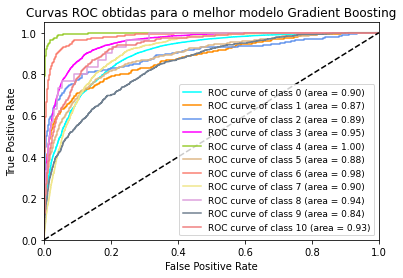

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle

colors = cycle(["aqua", "darkorange", "cornflowerblue", "magenta", "yellowgreen", "burlywood","salmon","khaki","plum","slategrey","lightcoral"])
for i, color in zip(range(11), colors):
    fpr, tpr, _ = roc_curve(y_test.to_numpy()[:,i], y_pred_gb[:,i])
    plt.plot(
        fpr,
        tpr,
        color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc_score(y_test, y_pred_gb, average=None)[i]),
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC obtidas para o melhor modelo Gradient Boosting")
plt.legend(loc="best", prop={'size': 9})
plt.savefig("roc_curve.pdf", format="pdf", bbox_inches="tight")
plt.show()